In [7]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [8]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [9]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [10]:
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # 计算价格波动率
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    
    # 计算量价比率
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    # 关键周期定义
    periods = [96, 288, 672, 1440, 2880]
    
    # 计算各周期量价比率
    vp_matrix = np.column_stack([
        vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
        for p in periods
    ])
    
    # 多尺度量价背离检测
    divergence_matrix = np.zeros((len(df), len(periods)))
    for i, p in enumerate(periods):
        # 价格动量
        price_momentum = df['close'].pct_change(p)
        
        # 成交量动量
        volume_momentum = df['volume'].pct_change(p)
        
        # 资金流动量
        flow_momentum = df['buy_ratio'].diff(p)
        
        # 量价背离检测
        price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
        
        # 价资背离检测
        price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
        
        # 综合背离强度
        div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) * np.abs(flow_momentum)
        
        # 在尾部区域放大背离信号
        is_tail = (df['buy_ratio'] < 0.25)
        div_strength = np.where(is_tail, div_strength * 1.5, div_strength)
        
        divergence_matrix[:, i] = div_strength
    
    # 组合特征矩阵
    combined_matrix = np.concatenate((vp_matrix, divergence_matrix), axis=1)
    
    # === 改进的滚动标准化方案 ===
    scaled_std = np.zeros_like(combined_matrix)
    window = 2800  # 2880=30天
    min_periods = 168
    
    for i in range(combined_matrix.shape[1]):
        col = pd.Series(combined_matrix[:, i])
        
        # 严格使用历史数据计算分位数
        rolling_q20 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.20)
        rolling_q80 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.80)
        
        # 动态分母保护
        denominator = rolling_q80 - rolling_q20
        adaptive_threshold = 0.01 * col.abs().rolling(288, min_periods=72).mean()
        denominator = np.where(denominator < 1e-5, adaptive_threshold, denominator)
        
        # 安全标准化
        scaled_col = (col - rolling_q20) / (denominator + 1e-7)
        
        # 缩尾处理
        scaled_col = np.clip(scaled_col, -3, 3)
        scaled_std[:, i] = scaled_col
    
    # 最终因子计算（增加尾部敏感性）
    tail_weight = np.where(df['buy_ratio'] < 0.25, 1.5, 1.0)
    factor = (np.mean(scaled_std, axis=1) * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight).values
        
    return factor

In [ ]:
# 1：引入波动率调整的背离强度
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # 实现波动率 (RV)
    ret = df['close'].pct_change()
    realized_vol = ret.rolling(96).std()
    
    # 隐含波动率 (IV) 代理指标 (创新点)
    # 使用价量关系构建IV代理：大单不平衡时的预期波动
    large_order = (df['taker_buy_volume'] - df['volume']/2).abs().gt(df['volume'].rolling(24).quantile(0.75))
    iv_proxy = realized_vol.copy()
    iv_proxy[large_order] = realized_vol[large_order] * 1.3
    
    # 波动率偏差 (核心)
    vol_deviation = iv_proxy - realized_vol.shift(1)
    
    # 量价背离检测 (波动率偏差加权)
    divergence_strength = np.zeros(len(df))
    periods = [24, 72, 144, 288]
    for p in periods:
        price_mom = df['close'].pct_change(p)
        flow_mom = df['buy_ratio'].diff(p)
        divergence = (np.sign(price_mom) != np.sign(flow_mom)).astype(float)
        # 波动率偏差放大效应
        divergence *= (1 + vol_deviation.clip(0, 0.5))
        divergence_strength += divergence
    
    # 标准化处理
    scaled_div = divergence_strength / len(periods)
    scaled_div = (scaled_div - scaled_div.rolling(672).mean()) / (scaled_div.rolling(672).std() + 1e-7)
    
    # 资金流强化
    flow_power = np.log1p(df['taker_buy_volume']) - np.log1p(df['volume'] - df['taker_buy_volume'])
    
    # 最终因子 (创新组合)
    factor = scaled_div * flow_power * np.where(vol_deviation > 0, 1.5, 1.0)
    
    # 尾部特殊处理
    tail_cond = (df['buy_ratio'] < 0.25) & (realized_vol > realized_vol.quantile(0.6))
    factor[tail_cond] = factor[tail_cond] * (1 + (0.25 - df['buy_ratio'][tail_cond])*2)
    
    return factor.values

In [ ]:
# 2：量价波动协同因子
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # 计算价格波动率 (改进)
    ret = df['close'].pct_change()
    price_vol = ret.ewm(alpha=0.05).std()
    
    # 计算成交量波动率 (新增核心指标)
    vol_vol = np.log1p(df['volume']).diff().abs().ewm(alpha=0.05).std()
    
    # 量价波动协同指标 (核心创新)
    vol_sync = price_vol / (vol_vol + 1e-7)
    vol_sync_score = vol_sync.rolling(96).apply(lambda x: x[-1]/x.mean() if x.mean()>0 else 1)
    
    # 关键周期定义
    periods = [96, 288, 672]
    
    # 多尺度量价背离检测 (重构)
    divergence_matrix = np.zeros((len(df), len(periods)))
    for i, p in enumerate(periods):
        # 价格动量 (波动率调整)
        price_momentum = df['close'].pct_change(p) / price_vol
        
        # 资金流动量
        flow_momentum = df['buy_ratio'].diff(p)
        
        # 量价背离检测 (加入协同指标)
        divergence = price_momentum * flow_momentum * vol_sync_score
        
        # 尾部增强 (协同指标过滤)
        is_tail = (df['buy_ratio'] < 0.25) & (vol_sync_score < 0.8)
        divergence = np.where(is_tail, divergence * 1.3, divergence)
        
        divergence_matrix[:, i] = divergence
    
    # 组合特征矩阵
    combined_matrix = divergence_matrix  # 简化结构
    
    # 动态标准化
    scaled_std = np.zeros_like(combined_matrix)
    for i in range(combined_matrix.shape[1]):
        col = pd.Series(combined_matrix[:, i])
        # 自适应窗口 (波动率驱动)
        vol_based_window = np.clip((vol_vol*1000).astype(int), 500, 5000)
        rolling_mean = col.shift(1).rolling(window=vol_based_window, min_periods=100).mean()
        rolling_std = col.shift(1).rolling(window=vol_based_window, min_periods=100).std()
        scaled_col = (col - rolling_mean) / (rolling_std + 1e-7)
        scaled_col = np.clip(scaled_col, -4, 4)
        scaled_std[:, i] = scaled_col
    
    # 最终因子计算 (波动率加权平均)
    weights = 1 / (price_vol + 0.05)  # 高波动时期降低权重
    weighted_avg = np.average(scaled_std, axis=1, weights=weights)
    
    return weighted_avg

In [ ]:
# 3：波动率分域处理
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # 波动率状态检测 (核心创新)
    ret = df['close'].pct_change().abs()
    short_vol = ret.rolling(24).mean()
    long_vol = ret.rolling(288).mean()
    vol_regime = (short_vol / long_vol).gt(1.2).astype(int)  # 0=低波动, 1=高波动
    
    # 分域计算因子
    factor_values = np.zeros(len(df))
    
    # 低波动区域因子 (侧重资金流)
    low_vol_mask = (vol_regime == 0)
    if low_vol_mask.any():
        # 资金流纯度指标
        fund_flow = df['buy_ratio'] - df['buy_ratio'].rolling(96).mean()
        # 量能压缩指标
        vol_compression = 1 / (1 + np.log1p(df['volume']).pct_change(72))
        factor_values[low_vol_mask] = (fund_flow * vol_compression)[low_vol_mask]
    
    # 高波动区域因子 (侧重量价背离)
    high_vol_mask = (vol_regime == 1)
    if high_vol_mask.any():
        # 动态周期选择
        vol_level = short_vol.rank(pct=True)
        dynamic_period = np.select(
            [vol_level < 0.3, vol_level > 0.7],
            [144, 24],
            default=72
        )
        
        # 动态量价背离
        price_mom = df['close'].pct_change(dynamic_period)
        volume_mom = np.log1p(df['volume']).diff(dynamic_period)
        divergence = np.sign(price_mom) != np.sign(volume_mom)
        flow_strength = df['buy_ratio'].diff(24).abs()
        
        factor_values[high_vol_mask] = (-divergence.astype(float) * flow_strength)[high_vol_mask]
    
    # 过渡区域平滑
    transition = vol_regime.diff().ne(0)
    if transition.any():
        # 使用混合算法平滑过渡
        smooth_factor = uniform_filter1d(factor_values, size=5)
        factor_values[transition] = smooth_factor[transition]
    
    # 尾部增强 (仅在高波动区域)
    tail_mask = (df['buy_ratio'] < 0.25) & high_vol_mask
    factor_values[tail_mask] = factor_values[tail_mask] * 1.5
    
    return factor_values

In [ ]:
# 1

def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # === 多重分形特征提取 ===
    # 1. 价格分形维度
    df['range'] = (df['high'] - df['low']) / df['open'].clip(lower=1e-5)
    df['fractal_price'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    # 2. 成交量分形维度
    log_vol = np.log1p(df['volume'])
    df['fractal_volume'] = log_vol.rolling(5).std() / log_vol.rolling(20).std()
    
    # 3. 资金流分形维度
    df['fractal_flow'] = df['buy_ratio'].rolling(5).std() / df['buy_ratio'].rolling(20).std()
    
    # 4. 分形协同指标
    df['fractal_sync'] = (df['fractal_price'] * df['fractal_volume'] * df['fractal_flow']) ** (1/3)
    
    # 计算价格波动率 (分形协同调整)
    price_change = df['close'].pct_change()
    volatility = price_change.rolling(96).std() * df['fractal_sync']
    
    # 计算量价比率
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    # 关键周期定义 (分形自适应)
    base_period = int(96 * (1 + (df['fractal_sync'] - 1).clip(-0.5, 0.5)))
    periods = [
        base_period, 
        base_period * 3, 
        base_period * 7, 
        base_period * 15, 
        base_period * 30
    ]
    
    # 计算各周期量价比率
    vp_matrix = np.column_stack([
        vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
        for p in periods
    ])
    
    # 多尺度量价背离检测 (分形协同增强)
    divergence_matrix = np.zeros((len(df), len(periods)))
    for i, p in enumerate(periods):
        # 价格动量
        price_momentum = df['close'].pct_change(p)
        
        # 成交量动量
        volume_momentum = df['volume'].pct_change(p)
        
        # 资金流动量
        flow_momentum = df['buy_ratio'].diff(p)
        
        # 量价背离检测
        price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
        
        # 价资背离检测
        price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
        
        # 综合背离强度 (分形协同加权)
        div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) 
        div_strength *= np.abs(flow_momentum) * df['fractal_sync']
        
        # 在尾部区域放大背离信号 (分形协同条件)
        is_tail = (df['buy_ratio'] < 0.25) & (df['fractal_sync'] > df['fractal_sync'].rolling(672).quantile(0.7))
        div_strength = np.where(is_tail, div_strength * 2.0, div_strength)
        
        divergence_matrix[:, i] = div_strength
    
    # 组合特征矩阵
    combined_matrix = np.concatenate((vp_matrix, divergence_matrix), axis=1)
    
    # === 分形自适应标准化 ===
    scaled_std = np.zeros_like(combined_matrix)
    
    for i in range(combined_matrix.shape[1]):
        col = pd.Series(combined_matrix[:, i])
        
        # 分形驱动的滚动窗口
        fractal_window = np.clip((df['fractal_sync'] * 2000).astype(int), 1000, 5000)
        rolling_q20 = col.shift(1).rolling(window=fractal_window, min_periods=168).quantile(0.20)
        rolling_q80 = col.shift(1).rolling(window=fractal_window, min_periods=168).quantile(0.80)
        
        # 动态分母保护
        denominator = rolling_q80 - rolling_q20
        adaptive_threshold = 0.01 * col.abs().rolling(288, min_periods=72).mean()
        denominator = np.where(denominator < 1e-5, adaptive_threshold, denominator)
        
        # 安全标准化
        scaled_col = (col - rolling_q20) / (denominator + 1e-7)
        
        # 分形敏感缩尾
        tail_bound = np.where(df['fractal_sync'] > 1.0, 4, 3)
        scaled_col = np.clip(scaled_col, -tail_bound, tail_bound)
        scaled_std[:, i] = scaled_col
    
    # 最终因子计算 (分形加权)
    fractal_weight = df['fractal_sync'].clip(0.5, 2.0)
    weighted_avg = np.average(scaled_std, axis=1, weights=fractal_weight)
    
    # 增加尾部敏感性 (分形协同调整)
    tail_weight = np.where(
        (df['buy_ratio'] < 0.25) & (df['fractal_sync'] > 1.0), 
        (1.5 + (df['fractal_sync'] - 1.0) * 2).clip(1.5, 3.0), 
        np.where(df['buy_ratio'] < 0.25, 1.2, 1.0)
    )
    
    factor = (weighted_avg * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight).values
        
    return factor

In [ ]:
# 2

def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # === 分形市场状态检测 ===
    # 1. 价格分形维度
    df['range'] = (df['high'] - df['low']) / df['open'].clip(lower=1e-5)
    df['fractal_price'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    # 2. 成交量分形维度
    log_vol = np.log1p(df['volume'])
    df['fractal_volume'] = log_vol.rolling(5).std() / log_vol.rolling(20).std()
    
    # 3. 分形市场状态
    conditions = [
        # 低波动稳态 (分形维度低)
        (df['fractal_price'] < 0.8) & (df['fractal_volume'] < 0.8),
        
        # 高波动分形态 (分形维度高)
        (df['fractal_price'] > 1.2) & (df['fractal_volume'] > 1.2),
        
        # 趋势耗竭态 (价格分形高但成交量分形低)
        (df['fractal_price'] > 1.2) & (df['fractal_volume'] < 0.7),
        
        # 流动性聚集态 (成交量分形高但价格分形低)
        (df['fractal_volume'] > 1.2) & (df['fractal_price'] < 0.8)
    ]
    
    states = [0, 1, 2, 3]  # 0:稳态, 1:高波动, 2:趋势耗竭, 3:流动性聚集
    df['market_state'] = np.select(conditions, states, default=0)
    
    # === 状态自适应因子计算 ===
    factor_values = np.zeros(len(df))
    
    # 公共参数
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    # 1. 低波动稳态市场
    mask0 = (df['market_state'] == 0)
    if mask0.any():
        # 重点：微观结构失衡
        imbalance = (df['taker_buy_volume'] - (df['volume'] - df['taker_buy_volume'])) / df['volume']
        # 短期量价背离
        short_term_div = np.sign(df['close'].pct_change(24)) * np.sign(df['volume'].pct_change(24)) < 0
        factor_values[mask0] = imbalance[mask0] * short_term_div[mask0].astype(float) * 1.5
    
    # 2. 高波动分形态市场
    mask1 = (df['market_state'] == 1)
    if mask1.any():
        # 多尺度量价背离检测 (原始VCF逻辑)
        periods = [96, 288, 672, 1440, 2880]
        divergence_matrix = np.zeros((len(df), len(periods)))
        
        for i, p in enumerate(periods):
            price_momentum = df['close'].pct_change(p)
            volume_momentum = df['volume'].pct_change(p)
            flow_momentum = df['buy_ratio'].diff(p)
            
            price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
            price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
            
            div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) 
            div_strength *= np.abs(flow_momentum) * (1 + (df['fractal_price'] - 1))
            
            # 在尾部区域放大
            is_tail = (df['buy_ratio'] < 0.25)
            div_strength = np.where(is_tail, div_strength * 2.0, div_strength)
            
            divergence_matrix[:, i] = div_strength
        
        # 组合特征矩阵
        vp_matrix = np.column_stack([
            vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
            for p in periods
        ])
        combined_matrix = np.concatenate((vp_matrix, divergence_matrix), axis=1)
        
        # 滚动标准化
        scaled_std = np.zeros_like(combined_matrix)
        window = 2800
        min_periods = 168
        
        for i in range(combined_matrix.shape[1]):
            col = pd.Series(combined_matrix[:, i])
            rolling_q20 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.20)
            rolling_q80 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.80)
            denominator = rolling_q80 - rolling_q20
            adaptive_threshold = 0.01 * col.abs().rolling(288, min_periods=72).mean()
            denominator = np.where(denominator < 1e-5, adaptive_threshold, denominator)
            scaled_col = (col - rolling_q20) / (denominator + 1e-7)
            scaled_col = np.clip(scaled_col, -4, 4)  # 高波动市场放宽范围
            scaled_std[:, i] = scaled_col
        
        # 最终计算
        weighted_avg = np.mean(scaled_std, axis=1)
        tail_weight = np.where(df['buy_ratio'] < 0.25, 2.0, 1.0)
        factor_values[mask1] = (weighted_avg * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight)[mask1]
    
    # 3. 趋势耗竭态市场
    mask2 = (df['market_state'] == 2)
    if mask2.any():
        # 重点：反转信号增强
        # 价格与资金流背离
        price_momentum = df['close'].pct_change(72)
        flow_momentum = df['buy_ratio'].diff(72)
        divergence = (np.sign(price_momentum) * np.sign(flow_momentum) < 0).astype(float)
        
        # 成交量压缩
        vol_compression = 1 / (1 + np.log1p(df['volume']).pct_change(48))
        
        factor_values[mask2] = (-divergence * np.abs(flow_momentum) * vol_compression * 3)[mask2]
    
    # 4. 流动性聚集态市场
    mask3 = (df['market_state'] == 3)
    if mask3.any():
        # 重点：大单流向分析
        large_order_threshold = df['volume'].rolling(96).quantile(0.75)
        is_large_buy = (df['taker_buy_volume'] > large_order_threshold)
        is_large_sell = ((df['volume'] - df['taker_buy_volume']) > large_order_threshold)
        
        # 大单净流向
        net_large_flow = (df['taker_buy_volume'] - (df['volume'] - df['taker_buy_volume'])) / df['volume']
        
        # 结合短期价格动量
        short_momentum = df['close'].pct_change(12)
        factor_values[mask3] = (net_large_flow * np.sign(short_momentum) * 2)[mask3]
    
    # 状态过渡平滑
    state_change = df['market_state'].diff().ne(0)
    factor_values[state_change] = factor_values[state_change] * 0.8
    
    return factor_values

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.015002
   Rank_IC (Spearman): 0.015741
📊 信息比率:
   IR: 0.401486
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 129158
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


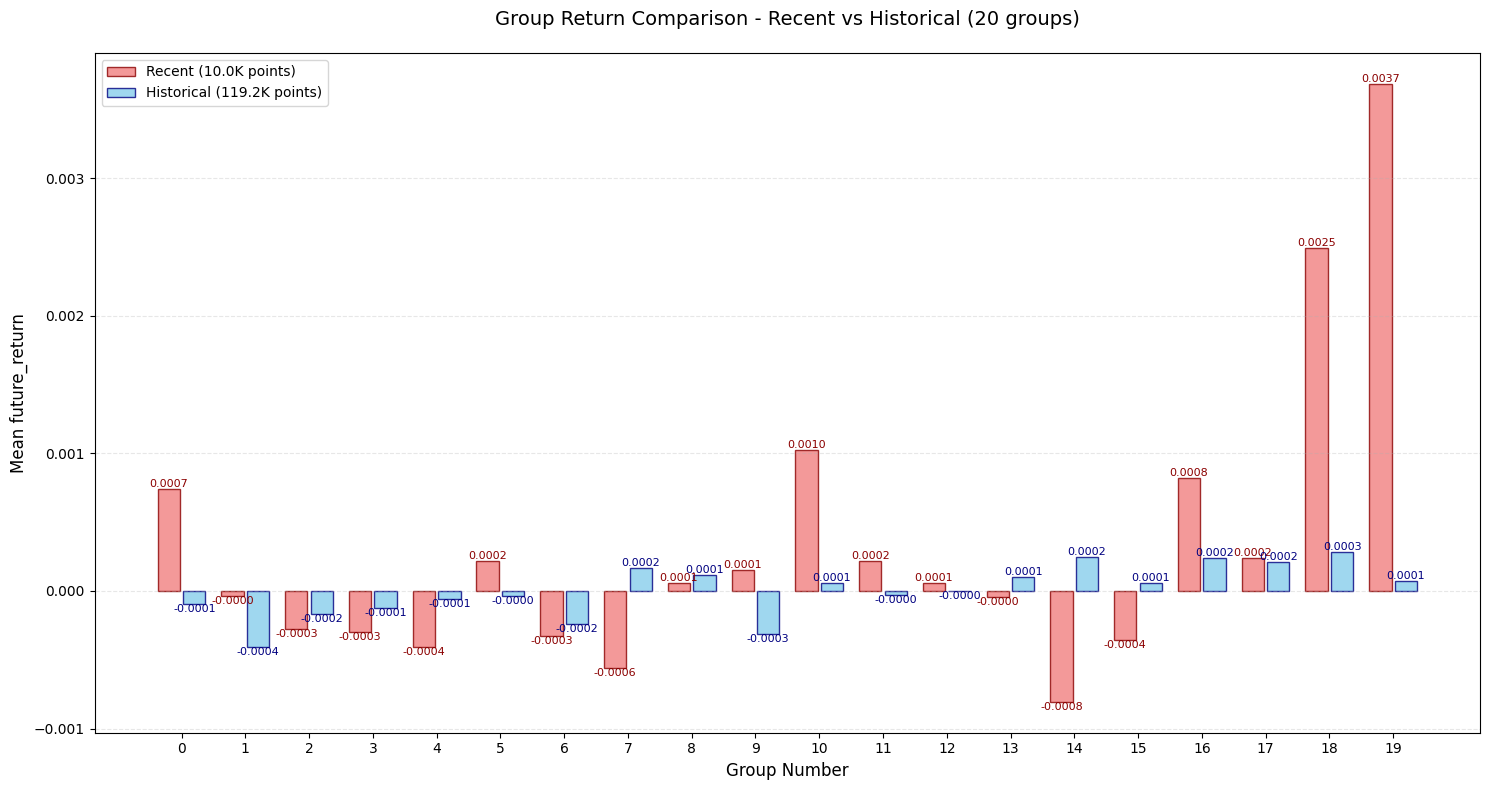

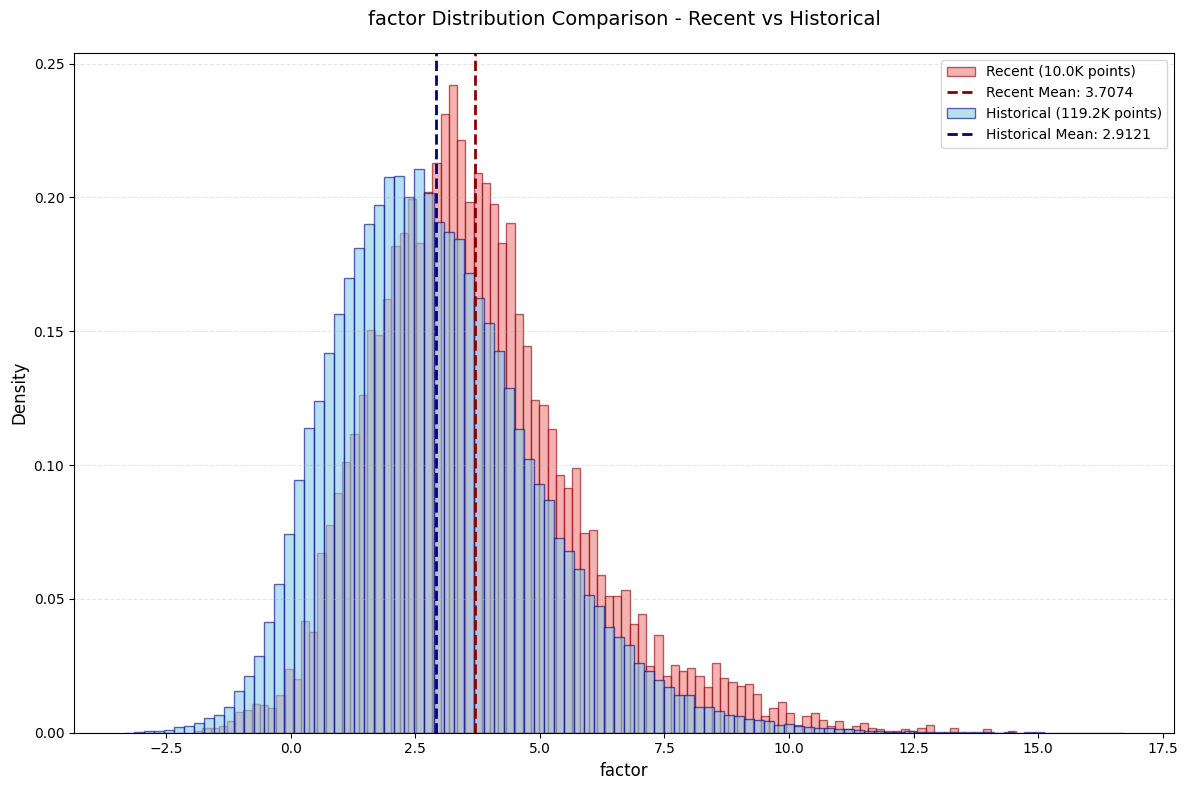

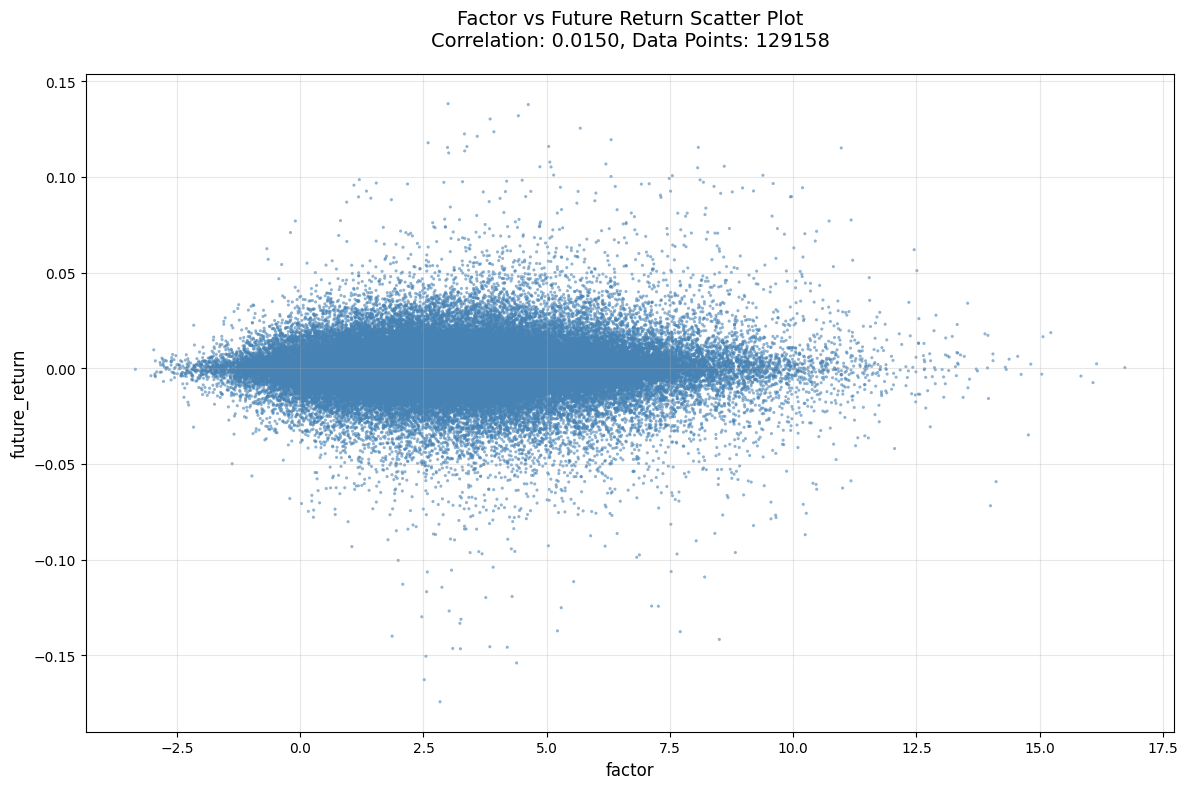

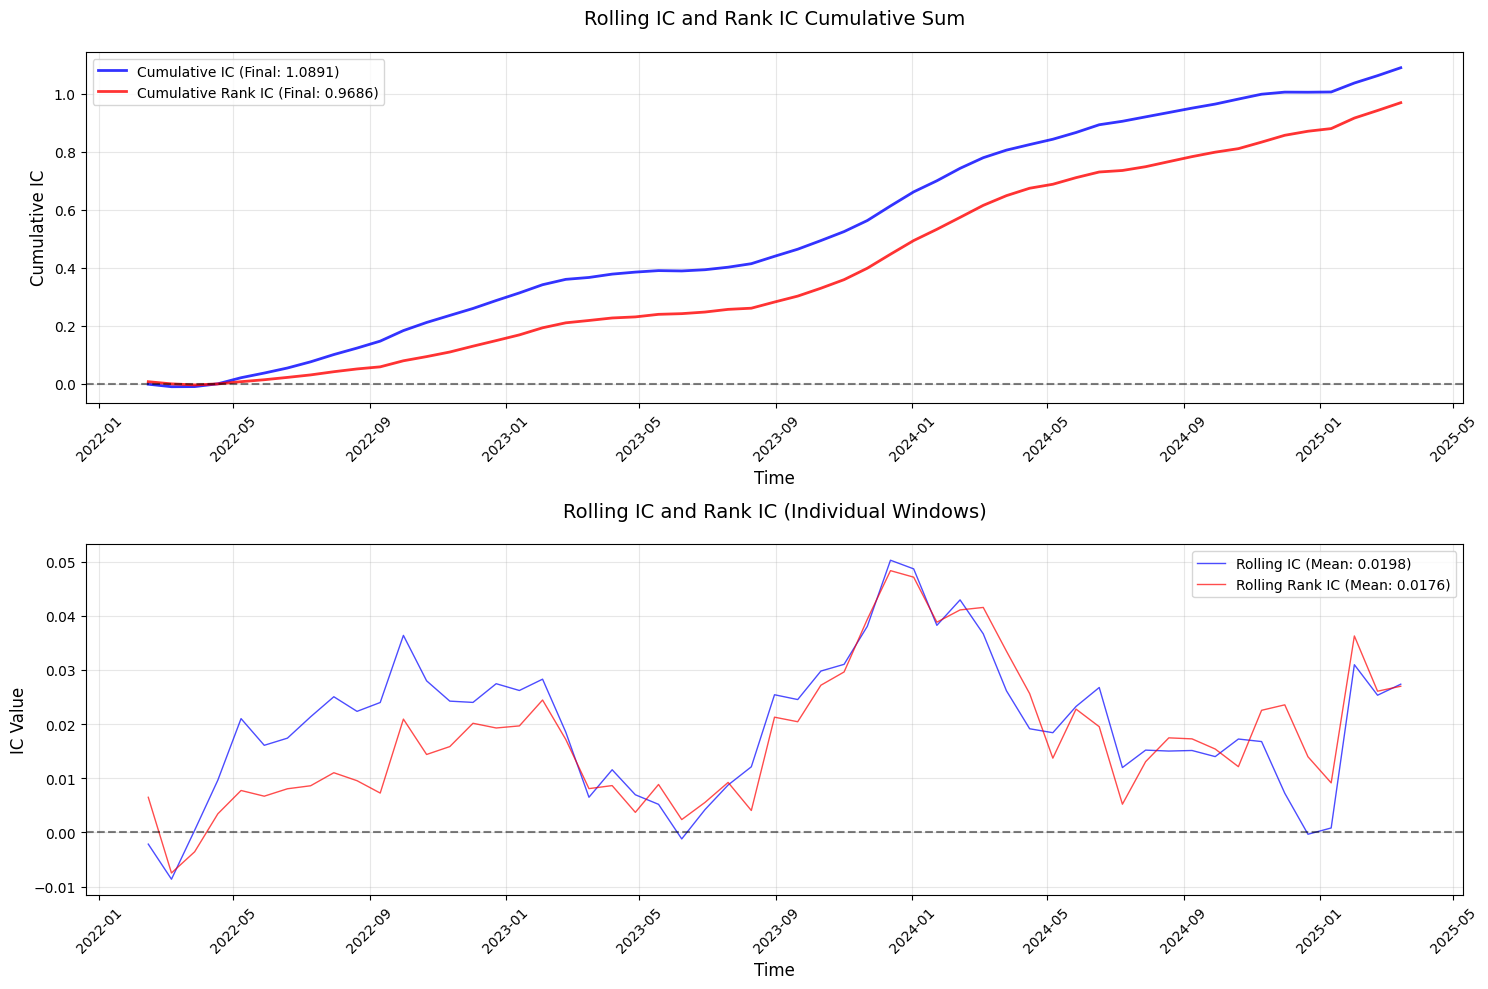

✅ 已显示 4 个图片
----------------------------------------


In [11]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [12]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+----------------------+
| 指标                | 值                   |
+=====================+======================+
| 信息系数(IC)        | 0.015002412738473832 |
+---------------------+----------------------+
| 秩相关系数(Rank IC) | 0.015740942649892082 |
+---------------------+----------------------+
| 信息比率(IR)        | 0.401486319341024    |
+---------------------+----------------------+
| 分组数量            | 10                   |
+---------------------+----------------------+
| 数据点数            | 129,158              |
+---------------------+----------------------+
| 异常值(>3σ)         | 7.09%                |
+---------------------+----------------------+
| 异常值(>5σ)         | 0.33%                |
+---------------------+----------------------+

                                     分组分析结果                                     
+--------+----------+----------+----------+------------+------------